get the dataset ready for training

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
IMG_SIZE=256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS =50

In [2]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size = BATCH_SIZE
)
class_names = dataset.class_names
class_names

Found 2152 files belonging to 3 classes.


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

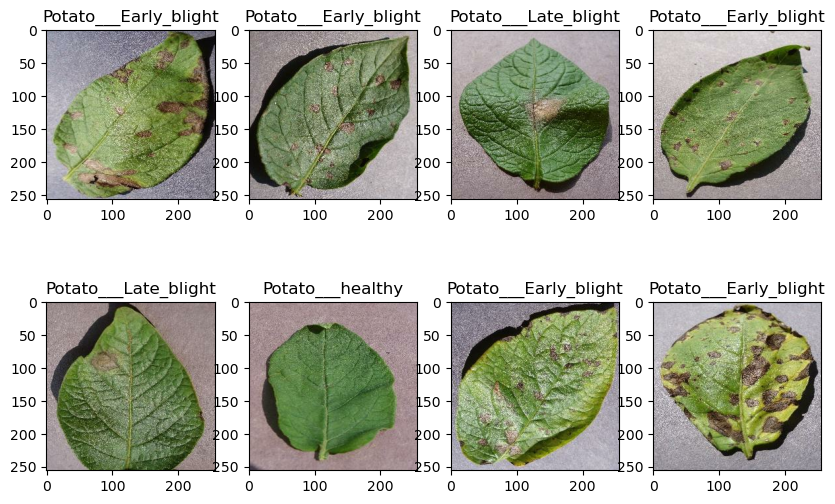

In [3]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(8):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8")) #try to visualise the imgs in folder
        plt.title(class_names[label_batch[i]])

Split 80-20 for train and split wehre the 20 test is split into 10 validation and 10 test

In [4]:
train_size = 0.8
len(dataset)*train_size #gives 54.400
train_ds = dataset.take(54)
len(train_ds)

54

In [5]:
test_ds=dataset.skip(54) 
len(test_ds)

14

In [6]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [7]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [8]:
test_ds = test_ds.skip(6)
len(test_ds)

8

Function takes tensorflow dataset, split ratio , shuffle size and return the values of what was done above

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size = 10000):
        assert (train_split + test_split + val_split) == 1
        
        ds_size = len(ds)
        
        if shuffle:
            ds = ds.shuffle(shuffle_size, seed=12)
        
        train_size = int(train_split * ds_size)
        val_size = int(val_split * ds_size)
        
        train_ds = ds.take(train_size)    
        val_ds = ds.skip(train_size).take(val_size)
        test_ds = ds.skip(train_size).skip(val_size)
        
        return train_ds, val_ds, test_ds
    
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


Cache , shuffle and prefetch the dataset


In [10]:

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
from tensorflow.keras.layers import Resizing, Rescaling

resize_and_rescale = tf.keras.Sequential([
    Resizing(IMG_SIZE, IMG_SIZE),
    Rescaling(1./255)
])


In [12]:
from tensorflow.keras.layers import RandomFlip, RandomRotation
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
])

Building a model using Convolutional Neural network


In [16]:
from tensorflow.keras import layers, models

input_shape = (256, 256, 3)  
n_classes = 3

model = models.Sequential([
    layers.Input(shape=input_shape),  
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(n_classes, activation='softmax')
])
#model architecture ready

In [17]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 516128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │       1,548,387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,549,283 (5.91 MB)

 Trainable params: 1,549,283 (5.91 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data = val_ds,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 50s 854ms/step - accuracy: 0.5860 - loss: 4.5941 - val_accuracy: 0.9062 - val_loss: 0.2596
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 75s 776ms/step - accuracy: 0.8782 - loss: 0.2889 - val_accuracy: 0.8177 - val_loss: 0.4432
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 774ms/step - accuracy: 0.9304 - loss: 0.2179 - val_accuracy: 0.9219 - val_loss: 0.2293
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 785ms/step - accuracy: 0.9208 - loss: 0.1962 - val_accuracy: 0.9479 - val_loss: 0.1579
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 794ms/step - accuracy: 0.8944 - loss: 0.2554 - val_accuracy: 0.9219 - val_loss: 0.1688
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 797ms/step - accuracy: 0.9426 - loss: 0.1543 - val_accuracy: 0.9583 - val_loss: 0.1162
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 785ms/step - accuracy: 0.9543 - loss: 0.1184 - val_accuracy: 0.9115 - val_loss: 0.2286
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 44s 815ms/step - accuracy: 0.9495 - loss: 0.1247 - val_accu

In [20]:
scores = model.evaluate(test_ds)
scores

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.9625 - loss: 0.1067


[0.12675841152668, 0.95703125]

In [21]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

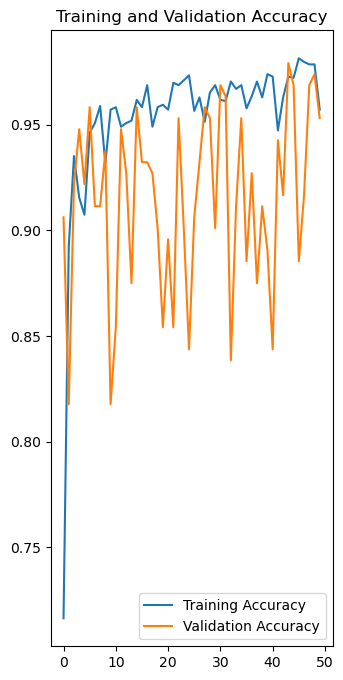

In [27]:
#plot the accuracy
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

Make predictions on sample of 32 images

First image to predict
Actual Label Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
predicted label:  Potato___Late_blight


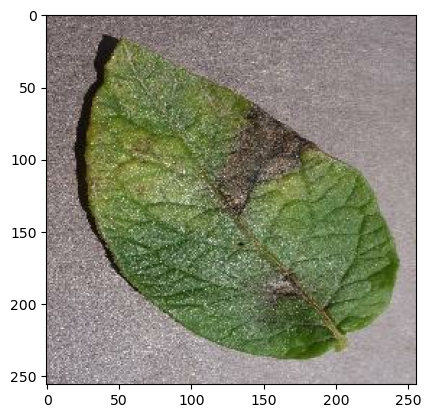

In [40]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print('First image to predict')
    plt.imshow(first_image)

    print('Actual Label',class_names[first_label])

    batch_prediction=model.predict(images_batch)
    print("predicted label: ",class_names[np.argmax(batch_prediction[0])])
    

Function which takes model and image as input and gives prediction just as above

In [43]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) #create batch
    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


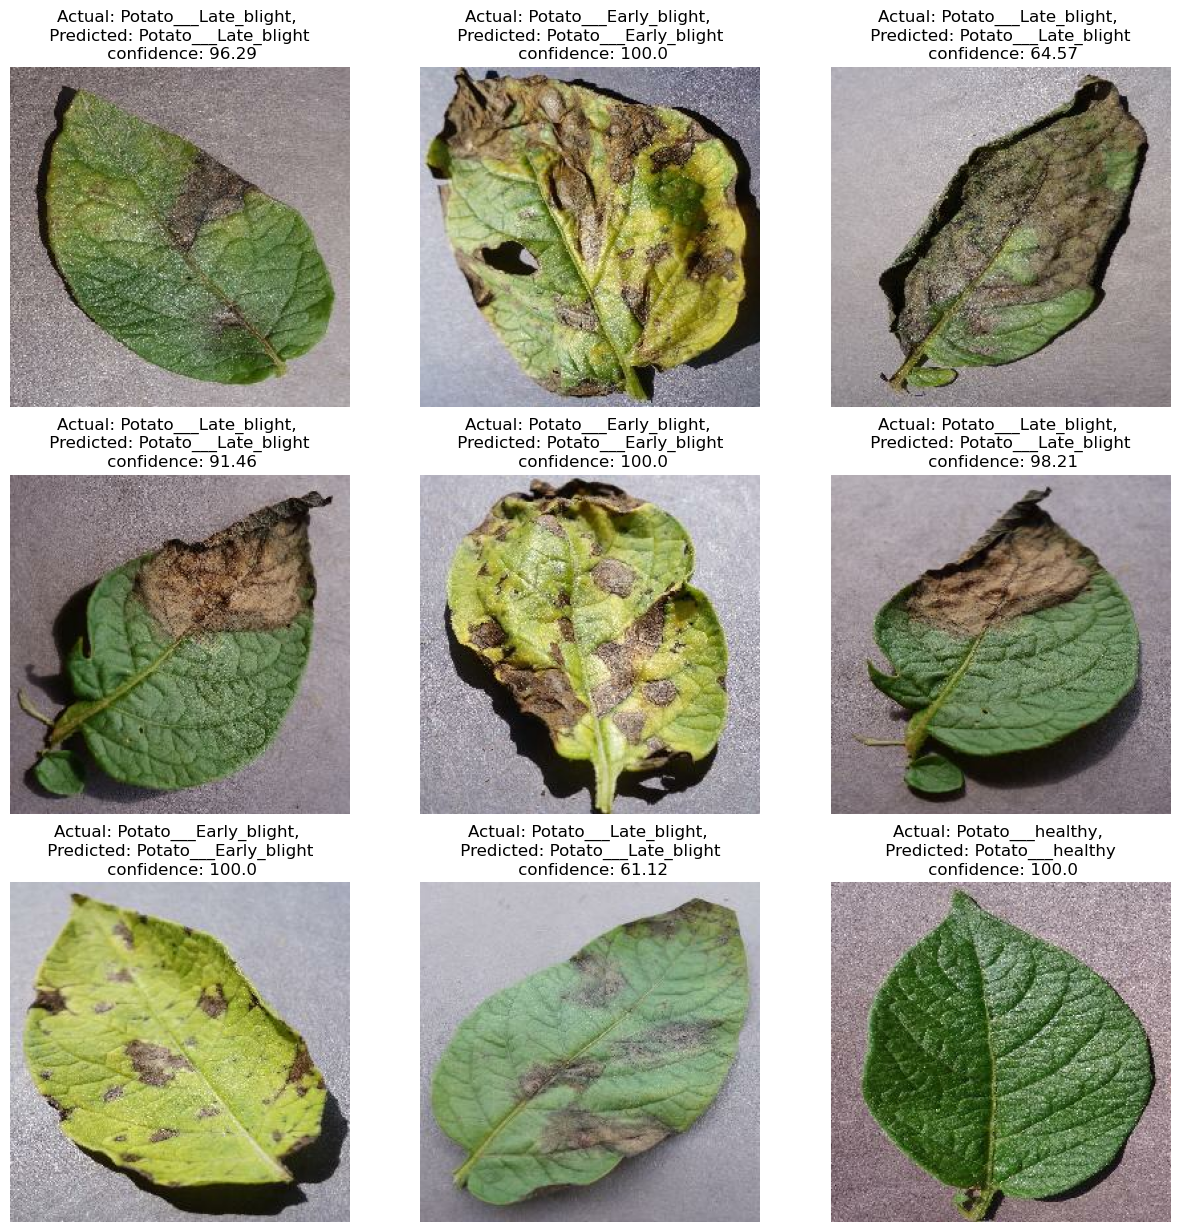

In [45]:
plt.figure(figsize=(15,15)) #bigger images
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class} \n confidence: {confidence}")
        plt.axis("off")

In [48]:
model_version = 1
model.save(f"../models/{model_version}.keras")